# Bedrock Claude 및 LangGraph 를 이용한 Prompt Flow - [Basic]

In [1]:
!python -V

Python 3.10.14


# 0. 환경 설정

In [2]:
%load_ext autoreload
%autoreload 2

import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)

module_path = "../.."
add_python_path(module_path)

python path: /home/sagemaker-user is added
sys.path:  ['/home/sagemaker-user/miridih-test/langgraph', '/opt/conda/lib/python310.zip', '/opt/conda/lib/python3.10', '/opt/conda/lib/python3.10/lib-dynload', '', '/home/sagemaker-user/.local/lib/python3.10/site-packages', '/opt/conda/lib/python3.10/site-packages', '/home/sagemaker-user']


In [3]:
# !pip install pydantic>=2.7.0
!pip show pydantic

Name: pydantic
Version: 2.9.1
Summary: Data validation using Python type hints
Home-page: https://github.com/pydantic/pydantic
Author: 
Author-email: Samuel Colvin <s@muelcolvin.com>, Eric Jolibois <em.jolibois@gmail.com>, Hasan Ramezani <hasan.r67@gmail.com>, Adrian Garcia Badaracco <1755071+adriangb@users.noreply.github.com>, Terrence Dorsey <terry@pydantic.dev>, David Montague <david@pydantic.dev>, Serge Matveenko <lig@countzero.co>, Marcelo Trylesinski <marcelotryle@gmail.com>, Sydney Runkle <sydneymarierunkle@gmail.com>, David Hewitt <mail@davidhewitt.io>, Alex Hall <alex.mojaki@gmail.com>
License: 
Location: /opt/conda/lib/python3.10/site-packages
Requires: annotated-types, pydantic-core, typing-extensions
Required-by: amazon_sagemaker_jupyter_scheduler, anthropic, confection, fastapi, gluonts, jupyter_scheduler, langchain, langchain-anthropic, langchain-core, langsmith, sagemaker-core, sagemaker-jupyterlab-extension-common, spacy, thinc, weasel


## Bedrock Client 생성

In [4]:
from pprint import pprint
from termcolor import colored
from utils import bedrock
from utils.bedrock import bedrock_info

boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: us-east-1
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-5-Sonnet': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Opus': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1'

### 모델 ID 및 Bedrock converse API 정의

In [5]:
from utils.bedrock import *

model_id = "anthropic.claude-3-haiku-20240307-v1:0"
# model_id = "anthropic.claude-3-5-sonnet-20240620-v1:0"

### 프롬프트의 베이스가 되는 프롬프트 템플릿 파일 경로 지정

In [13]:
from utils.cross_region_inference_prompt_util import *
from jinja2 import Template

prompt_folder = "prompt_template"
outline_prompt_file_name = "outline_prompt_template.txt"
slide_prompt_file_name = "slide_prompt_template.txt"

## 슬라이드 내용 생성 prompt template 로딩

prompt_file_name = "slide_prompt_template.txt"

slide_prompt_file_path = os.path.join(prompt_folder, prompt_file_name)

template_content = load_template_from_file(slide_prompt_file_path)
slide_prompt_template = Template(template_content)
slide_prompt = slide_prompt_template.render()

print("\n## Slide prompt template...")
print(slide_prompt)


## Slide prompt template...
You are an expert in creating impactful and professional PowerPoint presentations.
Your task is to create detailed content for a specific slide in 10-slide presentation in Korean, ensuring a logical flow and comprehensive coverage of the topic.

Based on this  of the , Generate detailed content for slides  to .
For each slide, include:
1. Slide title
2. Main content points (3-5 bullet points)
3. Relevant data or examples
4. Suggesion for visuals (e.g., image, chart, graph)
5. A brief speaker note (1-2 sentences)


# 1. Graph 정의

#### 그래프 정의
- State 정의
- 그래프 빌더 정의
- 노드, 에지 정의
- 그래프 컴파일

## 버전1: Aggregated graph - 프레젠테이션 1-5장, 6-10장 생성하는 노드 동시에 돌리기

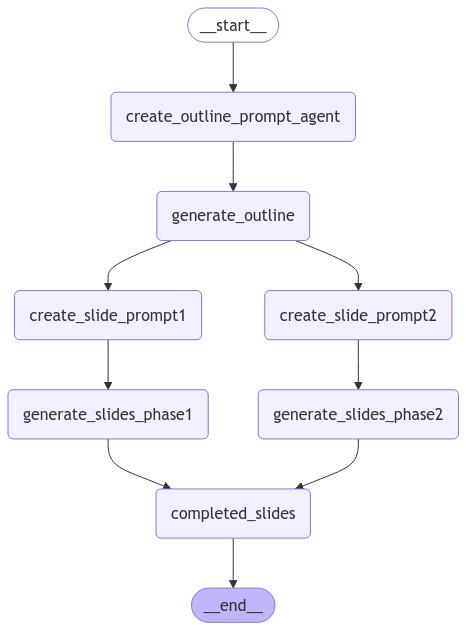

In [22]:
from typing import TypedDict, Annotated, Any
from langgraph.graph import StateGraph, START, END
from langchain_anthropic import ChatAnthropic

# State 정의
class State(TypedDict):
    topic: Annotated[str, "프레젠테이션 주제"]
    outline_prompt: Annotated[str, "프레젠테이션 개요 생성을 위해 실행할 프롬프트"]
    outline: Annotated[str, "프레젠테이션 개요"]
    slide_prompt_1: Annotated[str, "슬라이드 내용 생성을 위해 실행할 프롬프트(배치1)"]
    slide_prompt_2: Annotated[str, "슬라이드 내용 생성을 위해 실행할 프롬프트(배치2)"]
    slide_content_1: Annotated[str, "slide_prompt_1로 만들어진 프레젠테이션 내용"]
    slide_content_2: Annotated[str, "slide_prompt_2로 만들어진 프레젠테이션 내용"]
    completed_content: Annotated[str, "최종 생성된 프레젠테이션 내용"]

# 프레젠테이션의 개요를 생성하는 프롬프트 생성
def create_outline_prompt_agent(state:State)-> State:
    topic = state["topic"]

    prompt_file_path = os.path.join(prompt_folder, outline_prompt_file_name)
    template_content = load_template_from_file(prompt_file_path)
    PROMPT_TEMPLATE = Template(template_content)

    outline_prompt = PROMPT_TEMPLATE.render(topic=topic)
    print("\n## Generated Prompt for outline prompt")
    print(outline_prompt)
    return State(outline_prompt=outline_prompt)


# 프레젠테이션 개요 생성 노드 정의
def generate_outline(state: State) -> State:
    # llm = get_llm_model(model_id="claude-3-haiku-20240307):
    prompt = state["outline_prompt"]
    
    response = converse_invoke(boto3_bedrock, model_id, prompt)  
    # response = converse_invoke_with_backoff(boto3_bedrock, model_id, prompt)
    
    outline = response['output']['message']['content'][0]['text']
    print("\n## Generated outline")
    print("response: \n", outline)
    return State(outline=outline)


# # 생성한 프레젠테이션의 타이틀만 뽑아내는 노드 정의
# def extract_slide_titles(state: State) -> State:
#     # JSON 문자열을 Python 딕셔너리로 파싱
#     outline = state["outline"]
#     slide_titles = []
#     data = json.loads(outline) if isinstance(outline, str) else outline
#     # 메인 타이틀 출력
#     # title = data['title']
#     # 슬라이드 리스트를 순회하며 각 슬라이드의 제목 출력
#     print("\n## Extract each slide titles in outline...")
#     for slide in data['slides']:
#         print(slide)
#         slide_titles.append(slide['slide_title'])
#     return State(slide_titles=slide_titles)


def create_slide_prompt1(state: State) -> State:
    print("\n## Generating prompt for creating the content of slides 1-5...\n")
    
    topic = state["topic"]
    outline = state["outline"]

    slide_prompt1 = slide_prompt_template.render(
        topic = topic,
        outline = outline,
        start_slide = 1,
        end_slide = 5
    )
    print("\n### Generated Prompt for slides 1-5...")
    print(slide_prompt1)
    return State(slide_prompt_1=slide_prompt1)


def create_slide_prompt2(state: State) -> State:
    print("\n## Generating prompt for creating the content of slides 6-10...\n")
    
    topic = state["topic"]
    outline = state["outline"]

    slide_prompt2 = slide_prompt_template.render(
        topic = topic,
        outline = outline,
        start_slide = 6,
        end_slide = 10
    )
    print("\n### Generated Prompt for slides 6-10...")
    print(slide_prompt2)
    return State(slide_prompt_2=slide_prompt2)


def generate_slides_phase1(state:State) -> State:
    slide_prompt_1 = state["slide_prompt_1"]
    
    response1 = converse_invoke(boto3_bedrock, model_id, slide_prompt_1)
    # response1 = converse_invoke_with_backoff(boto3_bedrock, model_id, slide_prompt1)
    
    output_message1 = response1['output']['message']['content'][0]['text']
    print("\n### Generated content for slides 1-5...") 
    print(output_message1)
    return State(slide_content_1=output_message1)


def generate_slides_phase2(state:State) -> State:
    slide_prompt_2 = state["slide_prompt_2"]
 
    response2 = converse_invoke(boto3_bedrock, model_id, slide_prompt_2)
    # response2 = converse_invoke_with_backoff(boto3_bedrock, model_id, slide_prompt2)

    output_message2 = response2['output']['message']['content'][0]['text']
    print("\n### Generated content for slides 6-10...") 
    print(output_message2)
    return State(slide_content_2=output_message2)


def completed_slides(state:State) -> State:
    slide_content_1=state["slide_content_1"]
    slide_content_2=state["slide_content_2"]
    completed_content= slide_content_1 + slide_content_2
    print("\n## Merged contents...")
    print(completed_content)
    return State(completed_content=completed_content)


# 그래프 정의
graph_builder = StateGraph(State)

# Add nodes to the graph
graph_builder.add_node("create_outline_prompt_agent", create_outline_prompt_agent)
graph_builder.add_node("generate_outline", generate_outline)
graph_builder.add_node("generate_slides_phase1", generate_slides_phase1)
graph_builder.add_node("create_slide_prompt1", create_slide_prompt1)
graph_builder.add_node("generate_slides_phase2", generate_slides_phase2)
graph_builder.add_node("create_slide_prompt2", create_slide_prompt2)
graph_builder.add_node("completed_slides", completed_slides)

# Define the flow of execution
graph_builder.add_edge(START, "create_outline_prompt_agent")
graph_builder.add_edge("create_outline_prompt_agent", "generate_outline")
graph_builder.add_edge("generate_outline", "create_slide_prompt1")
graph_builder.add_edge("generate_outline", "create_slide_prompt2")
graph_builder.add_edge("create_slide_prompt1", "generate_slides_phase1")
graph_builder.add_edge("create_slide_prompt2", "generate_slides_phase2")

# Ensure concat_slides runs only after both generate_slides_phase1 and generate_slides_phase2
graph_builder.add_edge("generate_slides_phase1", "completed_slides")
graph_builder.add_edge("generate_slides_phase2", "completed_slides")

# End the graph
graph_builder.add_edge("completed_slides", END)


# 그래프 컴파일
graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### 그래프를 실행할 함수 정의

In [23]:
def run_prompt(topic: str):
    result = graph.invoke(State(topic=topic))
    return result["completed_content"]

In [24]:
TOPIC = "Korean traditional holidays"

In [25]:
run_prompt(TOPIC)


## Generated Prompt for outline prompt
You are an expert in creating impactful and professional PowerPoint presentations. 
Create a detailed outline for a 10-slide presentation in Korean, ensuring a logical flow and comprehensive coverage of the topic.

Analyze the given topic thoroughly to write in the provided <output_format> JSON format.
Return only the JSON object without additional tags or explanations.

<context>
Korean traditional holidays
</context>

<instruction>
1. Title:
   - Create a compelling and concise main title that captures the essence of the presentation.

2. Slides:
   - Generate 10 slides, including an opening and a closing slide.
   - For each slide:
     - Assign a slide_number (01 to 10).
     - Create a clear and informative slide_title.
     
3. Content Guidelines:
   - Ensure a logical flow and structure throughout the presentation.
   - Include an introduction slide (slide 02) and a conclusion slide (slide 09).   

4. Common Points:
   - Include the most i


## Generated outline
response: 
 {
    "title": "한국의 전통 공휴일",
    "slides": [
        {
            "slide_number": "01",
            "slide_title": "오늘의 주제: 한국의 전통 공휴일",
        },
        {
            "slide_number": "02",
            "slide_title": "한국의 공휴일 소개",
        },
        {
            "slide_number": "03",
            "slide_title": "설날(음력 새해)",
        },
        {
            "slide_number": "04",
            "slide_title": "추석(추석 명절)",
        },
        {
            "slide_number": "05",
            "slide_title": "한국의 다양한 공휴일",
        },
        {
            "slide_number": "06",
            "slide_title": "전통 공휴일의 역사와 의미",
        },
        {
            "slide_number": "07",
            "slide_title": "공휴일에 열리는 행사와 풍습",
        },
        {
            "slide_number": "08",
            "slide_title": "전통 공휴일의 현대적 의의",
        },
        {
            "slide_number": "09",
            "slide_title": "한국의 전통 공휴일 문화 계승",
        },
        {
            "slide_nu

"한국의 전통 공휴일\n\n1. 오늘의 주제: 한국의 전통 공휴일\n\n- 한국의 풍부한 문화와 역사를 반영하는 다양한 전통 공휴일\n- 설날, 추석 등 대표적인 명절의 의미와 풍속 소개\n- 한국 고유의 전통 공휴일이 현대에 어떻게 계승되고 있는지 살펴봄\n\n[데이터 또는 예시]\n- 한국에는 약 20여 개의 국가 공휴일이 있으며, 이 중 다수가 전통 공휴일\n\n[시각화 제안]\n- 한국의 전통 공휴일 달력 이미지\n- 한국의 전통 공휴일 관련 사진\n\n[발표자 메모]\n한국의 다양한 전통 공휴일에 대한 전반적인 소개를 통해 한국 문화 이해의 시작점을 제공합니다.\n\n2. 한국의 공휴일 소개\n\n- 국경일, 민속 명절, 종교 축제 등 다양한 종류의 공휴일\n- 주요 공휴일: 설날, 삼일절, 석가탄신일, 어린이날, 광복절, 추석, 한글날 등\n- 공휴일마다 고유한 의미와 풍속, 행사 등이 있음\n- 공휴일은 한국인의 정체성과 전통문화를 보여주는 중요한 창\n\n[데이터 또는 예시]\n- 한국의 법정 공휴일 목록\n- 각 공휴일의 기원과 특징\n\n[시각화 제안]\n- 한국의 주요 공휴일 달력\n- 공휴일별 대표적인 행사 및 풍습 사진\n\n[발표자 메모]\n한국의 다양한 공휴일 종류와 특징을 소개하여 전통 공휴일의 중요성을 이해할 수 있도록 합니다.\n\n3. 설날(음력 새해)\n\n- 음력 1월 1일, 가장 중요한 명절 중 하나\n- 가족들이 모여 세배, 차례 등의 전통 풍속 행하기\n- 민속놀이와 음식 나누기 등 즐거운 시간 보냄\n- 새해 소원 빌기, 가족 간의 화합과 소통 강조\n\n[데이터 또는 예시]\n- 설날 차례상 차림 구성\n- 대표적인 설날 민속놀이(윷놀이, 제기차기 등)\n\n[시각화 제안]\n- 설날 가족 모습 사진\n- 차례상 또는 설날 음식 이미지\n\n[발표자 메모]\n설날의 의미와 전통 풍속을 소개하여 가족 간의 유대와 화합을 강조합니다.\n\n4. 추석(추석 명절)\n\n- 음력 8월 15일, 한가위라고도 불리는 중요한 

### 그래프 실행

## 버전2: Simple graph - 순차적으로 1-5번 슬라이드가 만들어진 후에 6-10번 슬라이드를 만들어보기

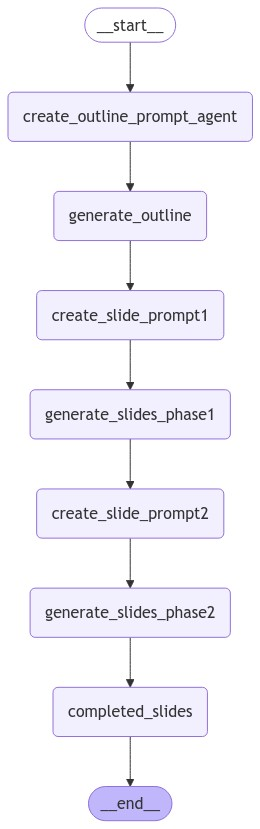

In [34]:
from typing import TypedDict, Annotated, Any
from langgraph.graph import StateGraph, START, END
from langchain_anthropic import ChatAnthropic

# State 정의
class State(TypedDict):
    topic: Annotated[str, "프레젠테이션 주제"]
    outline_prompt: Annotated[str, "프레젠테이션 개요 생성을 위해 실행할 프롬프트"]
    outline: Annotated[str, "프레젠테이션 개요"]
    slide_prompt_1: Annotated[str, "슬라이드 내용 생성을 위해 실행할 프롬프트(배치1)"]
    slide_prompt_2: Annotated[str, "슬라이드 내용 생성을 위해 실행할 프롬프트(배치2)"]
    slide_content_1: Annotated[str, "slide_prompt_1로 만들어진 프레젠테이션 내용"]
    slide_content_2: Annotated[str, "slide_prompt_2로 만들어진 프레젠테이션 내용"]
    completed_content: Annotated[str, "최종 생성된 프레젠테이션 내용"]

# 프레젠테이션의 개요를 생성하는 프롬프트 생성
def create_outline_prompt_agent(state:State)-> State:
    topic = state["topic"]

    prompt_file_path = os.path.join(prompt_folder, outline_prompt_file_name)
    template_content = load_template_from_file(prompt_file_path)
    PROMPT_TEMPLATE = Template(template_content)

    outline_prompt = PROMPT_TEMPLATE.render(topic=topic)
    print("\n## Generated Prompt for outline prompt")
    print(outline_prompt)
    return State(outline_prompt=outline_prompt)


# 프레젠테이션 개요 생성 노드 정의
def generate_outline(state: State) -> State:
    # llm = get_llm_model(model_id="claude-3-haiku-20240307):
    prompt = state["outline_prompt"]
    
    response = converse_invoke(boto3_bedrock, model_id, prompt)  
    # response = converse_invoke_with_backoff(boto3_bedrock, model_id, prompt)
    
    outline = response['output']['message']['content'][0]['text']
    print("\n## Generated outline")
    print("response: \n", outline)
    return State(outline=outline)


# # 생성한 프레젠테이션의 타이틀만 뽑아내는 노드 정의
# def extract_slide_titles(state: State) -> State:
#     # JSON 문자열을 Python 딕셔너리로 파싱
#     outline = state["outline"]
#     slide_titles = []
#     data = json.loads(outline) if isinstance(outline, str) else outline
#     # 메인 타이틀 출력
#     # title = data['title']
#     # 슬라이드 리스트를 순회하며 각 슬라이드의 제목 출력
#     print("\n## Extract each slide titles in outline...")
#     for slide in data['slides']:
#         print(slide)
#         slide_titles.append(slide['slide_title'])
#     return State(slide_titles=slide_titles)


def create_slide_prompt1(state: State) -> State:
    print("\n## Generating prompt for creating the content of slides 1-5...\n")
    
    topic = state["topic"]
    outline = state["outline"]

    slide_prompt1 = slide_prompt_template.render(
        topic = topic,
        outline = outline,
        start_slide = 1,
        end_slide = 5
    )
    print("\n### Generated Prompt for slides 1-5...")
    print(slide_prompt1)
    return State(slide_prompt_1=slide_prompt1)


def create_slide_prompt2(state: State) -> State:
    print("\n## Generating prompt for creating the content of slides 6-10...\n")
    
    topic = state["topic"]
    outline = state["outline"]

    slide_prompt2 = slide_prompt_template.render(
        topic = topic,
        outline = outline,
        start_slide = 6,
        end_slide = 10
    )
    print("\n### Generated Prompt for slides 6-10...")
    print(slide_prompt2)
    return State(slide_prompt_2=slide_prompt2)


def generate_slides_phase1(state:State) -> State:
    slide_prompt_1 = state["slide_prompt_1"]
    
    response1 = converse_invoke(boto3_bedrock, model_id, slide_prompt_1)
    # response1 = converse_invoke_with_backoff(boto3_bedrock, model_id, slide_prompt1)
    
    output_message1 = response1['output']['message']['content'][0]['text']
    print("\n### Generated content for slides 1-5...") 
    print(output_message1)
    return State(slide_content_1=output_message1)


def generate_slides_phase2(state:State) -> State:
    slide_prompt_2 = state["slide_prompt_2"]
 
    response2 = converse_invoke(boto3_bedrock, model_id, slide_prompt_2)
    # response2 = converse_invoke_with_backoff(boto3_bedrock, model_id, slide_prompt2)

    output_message2 = response2['output']['message']['content'][0]['text']
    print("\n### Generated content for slides 6-10...") 
    print(output_message2)
    return State(slide_content_2=output_message2)


def completed_slides(state:State) -> State:
    slide_content_1=state["slide_content_1"]
    slide_content_2=state["slide_content_2"]
    completed_content= slide_content_1 + slide_content_2
    print("\n## Merged contents...")
    print(completed_content)
    return State(completed_content=completed_content)

# 그래프 정의
graph_builder = StateGraph(State)


# Add nodes to the graph
graph_builder.add_node("create_outline_prompt_agent", create_outline_prompt_agent)
graph_builder.add_node("generate_outline", generate_outline)
graph_builder.add_node("generate_slides_phase1", generate_slides_phase1)
graph_builder.add_node("create_slide_prompt1", create_slide_prompt1)
graph_builder.add_node("generate_slides_phase2", generate_slides_phase2)
graph_builder.add_node("create_slide_prompt2", create_slide_prompt2)
graph_builder.add_node("completed_slides", completed_slides)

# Define the flow of execution
graph_builder.add_edge(START, "create_outline_prompt_agent")
graph_builder.add_edge("create_outline_prompt_agent", "generate_outline")
graph_builder.add_edge("generate_outline", "create_slide_prompt1")
graph_builder.add_edge("create_slide_prompt1", "generate_slides_phase1")
graph_builder.add_edge("generate_slides_phase1", "create_slide_prompt2")
graph_builder.add_edge("create_slide_prompt2", "generate_slides_phase2")
graph_builder.add_edge("generate_slides_phase2", "completed_slides")

# End the graph
graph_builder.add_edge("completed_slides", END)

# 그래프 컴파일
graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### 그래프를 실행할 함수 정의

In [35]:
def run_prompt(topic: str):
    result = graph.invoke(State(topic=topic))
    return result["completed_content"]

In [36]:
TOPIC = "Korean traditional holidays"

In [37]:
run_prompt(TOPIC)


## Generated Prompt for outline prompt
You are an expert in creating impactful and professional PowerPoint presentations. 
Create a detailed outline for a 10-slide presentation in Korean, ensuring a logical flow and comprehensive coverage of the topic.

Analyze the given topic thoroughly to write in the provided <output_format> JSON format.
Return only the JSON object without additional tags or explanations.

<context>
Korean traditional holidays
</context>

<instruction>
1. Title:
   - Create a compelling and concise main title that captures the essence of the presentation.

2. Slides:
   - Generate 10 slides, including an opening and a closing slide.
   - For each slide:
     - Assign a slide_number (01 to 10).
     - Create a clear and informative slide_title.
     
3. Content Guidelines:
   - Ensure a logical flow and structure throughout the presentation.
   - Include an introduction slide (slide 02) and a conclusion slide (slide 09).   

4. Common Points:
   - Include the most i


## Generated outline
response: 
 {
    "title": "한국의 전통 명절",
    "slides": [
        {
            "slide_number": "01",
            "slide_title": "한국 전통 명절 소개"
        },
        {
            "slide_number": "02",
            "slide_title": "명절의 중요성과 의미"
        },
        {
            "slide_number": "03",
            "slide_title": "설날 (Seollal)"
        },
        {
            "slide_number": "04",
            "slide_title": "추석 (Chuseok)"
        },
        {
            "slide_number": "05",
            "slide_title": "단오 (Dano)"
        },
        {
            "slide_number": "06",
            "slide_title": "한가위 (Hangawi)"
        },
        {
            "slide_number": "07",
            "slide_title": "한국 전통 음식과 놀이"
        },
        {
            "slide_number": "08",
            "slide_title": "한국 전통 명절의 가치"
        },
        {
            "slide_number": "09",
            "slide_title": "명절의 미래와 발전"
        },
        {
            "slide_number": "10",
           

'슬라이드 1: 한국 전통 명절 소개\n\n1. 슬라이드 제목:\n한국 전통 명절 소개\n\n2. 주요 내용 포인트:\n- 한국 전통 명절의 정의와 특징\n- 한국 전통 명절의 유래와 역사적 배경\n- 한국 전통 명절의 종류와 대표적인 명절\n- 한국 전통 명절의 문화적 가치와 의미\n- 한국 전통 명절의 현대적 변화와 계승\n\n3. 관련 데이터 또는 예시:\n- 한국의 주요 전통 명절 연혁 및 개요\n- 한국 전통 명절별 대표적인 풍습과 의식\n\n4. 비주얼 제안:\n- 한국 전통 명절의 대표적인 이미지(전통의복, 음식, 행사 등)\n- 한국 전통 명절의 문화적 특징을 나타내는 인포그래픽\n\n5. 발표자 메모:\n한국 전통 명절은 오랜 역사와 전통을 가지고 있으며, 한국 문화의 핵심적인 요소로 자리잡고 있습니다. 이번 슬라이드에서는 한국 전통 명절의 개요와 특징을 소개하겠습니다.\n\n슬라이드 2: 명절의 중요성과 의미\n\n1. 슬라이드 제목:\n명절의 중요성과 의미\n\n2. 주요 내용 포인트:\n- 한국 전통 명절의 역사적 유래와 발전\n- 한국 전통 명절의 사회적, 문화적, 가족적 의미\n- 한국 전통 명절이 한국인의 삶에 미치는 영향\n- 한국 전통 명절이 지니는 정신적, 윤리적 가치\n- 한국 전통 명절의 현대적 의미와 가치 변화\n\n3. 관련 데이터 또는 예시:\n- 한국 전통 명절의 주요 행사와 의식\n- 한국 전통 명절이 가족 및 지역사회에 미치는 영향\n\n4. 비주얼 제안:\n- 한국 전통 명절의 대표적인 풍습과 의식을 보여주는 이미지\n- 한국 전통 명절이 한국인의 삶에 미치는 영향을 나타내는 인포그래픽\n\n5. 발표자 메모:\n한국 전통 명절은 단순히 휴식과 여가를 위한 것이 아니라, 한국인의 정체성과 문화를 반영하는 중요한 의미를 지니고 있습니다. 이번 슬라이드에서는 명절의 역사적 배경과 사회적, 문화적 의미에 대해 알아보겠습니다.\n\n슬라이드 3: 설날 (Seollal)\n\n1. 슬라이드 제목:\n설날 (Seollal)